In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Time series libraries
import statsmodels.api as sm
import ruptures as rpt
from scipy.signal import find_peaks



In [2]:
df = pd.read_csv('Data/engines_data_cleaned.csv') 

# Display the first few rows of the dataframe
df.head()


eposition flight_phase eng_install_date  cycles  egt_probe_average  \
0          1      TAKEOFF   19-01-20 22:00    37.0           810.5125   
1          1        CLIMB   19-01-20 22:00    38.0           851.5125   
2          1       CRUISE   19-01-20 22:00    38.0           754.8250   
3          1       CRUISE   19-01-20 22:00    38.0           577.1125   
4          1      TAKEOFF   19-01-20 22:00    38.0           876.5125   

   fuel_flw  corrected_fan_spd  core_spd  zpn12p  vib_n1_#1_bearing  \
0    1520.0                NaN    103.19   79.21             0.1000   
1    5373.0                NaN    105.20   89.15             0.1267   
2    2431.0                NaN    102.94   83.01             0.1133   
3    1749.0                NaN     94.61   53.87             0.0733   
4    1476.0            82.9875    106.00   84.16             0.0600   

   vib_n2_#1_bearing  vib_n2_turbine_frame  eng_type  eng_number  \
0              0.275                  0.70         2           1   
1              0.375                  0.50         2           1   
2              0.425                  0.55         2           1   
3              0.050                  0.85         2           1   
4              0.225                  0.60         2           1   

     flight_datetime_c        date      time  flight_cycle   RUL  
0  2020-02-29 07:09:00  2020-02-29  07:09:00             1  4428  
1  2020-02-29 07:10:00  2020-02-29  07:10:00             1  4428  
2  2020-02-29 08:41:00  2020-02-29  08:41:00             1  4428  
3  2020-02-29 09:34:00  2020-02-29  09:34:00             1  4428  
4  2020-02-29 11:33:00  2020-02-29  11:33:00             2  4427

In [3]:
# Display information about the dataframe
df.info()

# Display descriptive statistics
df.describe()

# Count the number of unique engine IDs
print(f"\n \n Number of engines in this Dataset: {df['eng_number'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120677 entries, 0 to 120676
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   eposition             120677 non-null  int64  
 1   flight_phase          120677 non-null  object 
 2   eng_install_date      120677 non-null  object 
 3   cycles                120672 non-null  float64
 4   egt_probe_average     120610 non-null  float64
 5   fuel_flw              120603 non-null  float64
 6   corrected_fan_spd     79972 non-null   float64
 7   core_spd              120643 non-null  float64
 8   zpn12p                120643 non-null  float64
 9   vib_n1_#1_bearing     120379 non-null  float64
 10  vib_n2_#1_bearing     120377 non-null  float64
 11  vib_n2_turbine_frame  120379 non-null  float64
 12  eng_type              120677 non-null  int64  
 13  eng_number            120677 non-null  int64  
 14  flight_datetime_c     120677 non-null  object 
 15  

In [4]:
# Count the occurrences of each flight phase
df['flight_phase'].value_counts()

flight_phase
CRUISE     45057
TAKEOFF    37890
CLIMB      37730
Name: count, dtype: int64

In [5]:
# Handle missing values (check for NaNs)
df.isna().sum()

eposition                   0
flight_phase                0
eng_install_date            0
cycles                      5
egt_probe_average          67
fuel_flw                   74
corrected_fan_spd       40705
core_spd                   34
zpn12p                     34
vib_n1_#1_bearing         298
vib_n2_#1_bearing         300
vib_n2_turbine_frame      298
eng_type                    0
eng_number                  0
flight_datetime_c           0
date                        0
time                        0
flight_cycle                0
RUL                         0
dtype: int64

In [6]:
(df.isna().sum() / len(df)) * 100

eposition                0.000000
flight_phase             0.000000
eng_install_date         0.000000
cycles                   0.004143
egt_probe_average        0.055520
fuel_flw                 0.061321
corrected_fan_spd       33.730537
core_spd                 0.028174
zpn12p                   0.028174
vib_n1_#1_bearing        0.246940
vib_n2_#1_bearing        0.248597
vib_n2_turbine_frame     0.246940
eng_type                 0.000000
eng_number               0.000000
flight_datetime_c        0.000000
date                     0.000000
time                     0.000000
flight_cycle             0.000000
RUL                      0.000000
dtype: float64

In [7]:
# Use linear interpolation to fill missing values of the following features egt_probe_average, fuel_flw, corrected_fan_spd        34
# zpn12p, vib_n1_#1_bearing, vib_n2_#1_bearing, vib_n2_turbine_frame
feature_impute = ['egt_probe_average', 'fuel_flw','core_spd', 'zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame']
for feature in feature_impute:
    df[feature] = df[feature].interpolate(method='linear', limit_direction='both')

In [8]:
# Check if there are still any missing values
df.isna().sum()

eposition                   0
flight_phase                0
eng_install_date            0
cycles                      5
egt_probe_average           0
fuel_flw                    0
corrected_fan_spd       40705
core_spd                    0
zpn12p                      0
vib_n1_#1_bearing           0
vib_n2_#1_bearing           0
vib_n2_turbine_frame        0
eng_type                    0
eng_number                  0
flight_datetime_c           0
date                        0
time                        0
flight_cycle                0
RUL                         0
dtype: int64

In [9]:
# Check which flight phases have missing values of corrected_fan_spd
df[df['corrected_fan_spd'].isna()]['flight_phase'].value_counts()

flight_phase
CLIMB      37730
CRUISE      2865
TAKEOFF      110
Name: count, dtype: int64

* corrected_fan_spd feature could be use with flight phase TAKEOFF only.        

In [10]:
# Use linear interpolation to fill missing values of corrected_fan_spd for the TAKEOFF phase only
df.loc[df['flight_phase'] == 'TAKEOFF', 'corrected_fan_spd'] = df.loc[df['flight_phase'] == 'TAKEOFF', 'corrected_fan_spd'].interpolate(method='linear', limit_direction='both')

In [11]:
# Check which flight phases have missing values of corrected_fan_spd
df[df['corrected_fan_spd'].isna()]['flight_phase'].value_counts()

flight_phase
CLIMB     37730
CRUISE     2865
Name: count, dtype: int64

In [26]:
# print life of each engine in flight_cycle
max_life = df.groupby('eng_number')['flight_cycle'].max().reset_index()
max_life.columns = ['eng_number', 'life in flight cycle']
print(max_life)

    eng_number  life in flight cycle
0            1                  4429
1            2                  4690
2            3                  4510
3            4                  4035
4            5                  4427
5            6                  4089
6            7                  3975
7            8                  2018
8            9                  1888
9           10                  1967
10          11                  1862


In [12]:
# make a new data frome for eng_type 2 only
df_eng2 = df[df['eng_type'] == 2].copy()
# Check the number of engines in this new dataframe
df_eng2['eng_number'].nunique()

7

In [47]:
# Outlier detection using Z-score method
numerical_features = ['egt_probe_average', 'fuel_flw','core_spd', 'zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame', 'corrected_fan_spd']
from scipy import stats
from scipy.stats import zscore
# Calculate Z-scores for the specified features per phase
z_scores = df_eng2.groupby('flight_phase')[numerical_features].transform(lambda x: np.abs(stats.zscore(x, nan_policy='omit')))
# Define a threshold for identifying outliers
threshold = 2.5
# Identify outliers based on Z-scores
outliers = (z_scores > threshold).any(axis=1)
# Create a new DataFrame without outliers
df_eng2_no_outliers = df_eng2[~outliers].copy()
# Check the number of engines in the new dataframe without outliers
print(f"number of engines in the new dataframe without outliers {df_eng2_no_outliers['eng_number'].nunique()}")
# Calculate the percentage of records removed
removed_percentage = (df_eng2.shape[0] - df_eng2_no_outliers.shape[0]) / df_eng2.shape[0] * 100
print(f"Percentage of records removed: {removed_percentage:.2f}%")


number of engines in the new dataframe without outliers 7
Percentage of records removed: 10.81%


In [22]:
# save dataframe without outliers to a new CSV file
df_eng2_no_outliers.to_csv('Data/engines2_data_cleaned_no_outliers.csv', index=False)

In [28]:
df_eng2_no_outliers.head()

eposition flight_phase eng_install_date  cycles  egt_probe_average  \
0          1      TAKEOFF   19-01-20 22:00    37.0           810.5125   
1          1        CLIMB   19-01-20 22:00    38.0           851.5125   
2          1       CRUISE   19-01-20 22:00    38.0           754.8250   
4          1      TAKEOFF   19-01-20 22:00    38.0           876.5125   
5          1        CLIMB   19-01-20 22:00    39.0           870.5875   

   fuel_flw  corrected_fan_spd  core_spd  zpn12p  vib_n1_#1_bearing  \
0    1520.0            82.9875    103.19   79.21             0.1000   
1    5373.0                NaN    105.20   89.15             0.1267   
2    2431.0                NaN    102.94   83.01             0.1133   
4    1476.0            82.9875    106.00   84.16             0.0600   
5    5239.0                NaN    106.23   89.70             0.1267   

   vib_n2_#1_bearing  vib_n2_turbine_frame  eng_type  eng_number  \
0              0.275                  0.70         2           1   
1              0.375                  0.50         2           1   
2              0.425                  0.55         2           1   
4              0.225                  0.60         2           1   
5              0.150                  0.45         2           1   

     flight_datetime_c        date      time  flight_cycle   RUL  
0  2020-02-29 07:09:00  2020-02-29  07:09:00             1  4428  
1  2020-02-29 07:10:00  2020-02-29  07:10:00             1  4428  
2  2020-02-29 08:41:00  2020-02-29  08:41:00             1  4428  
4  2020-02-29 11:33:00  2020-02-29  11:33:00             2  4427  
5  2020-02-29 11:33:00  2020-02-29  11:33:00             2  4427

<Figure size 1200x600 with 0 Axes>

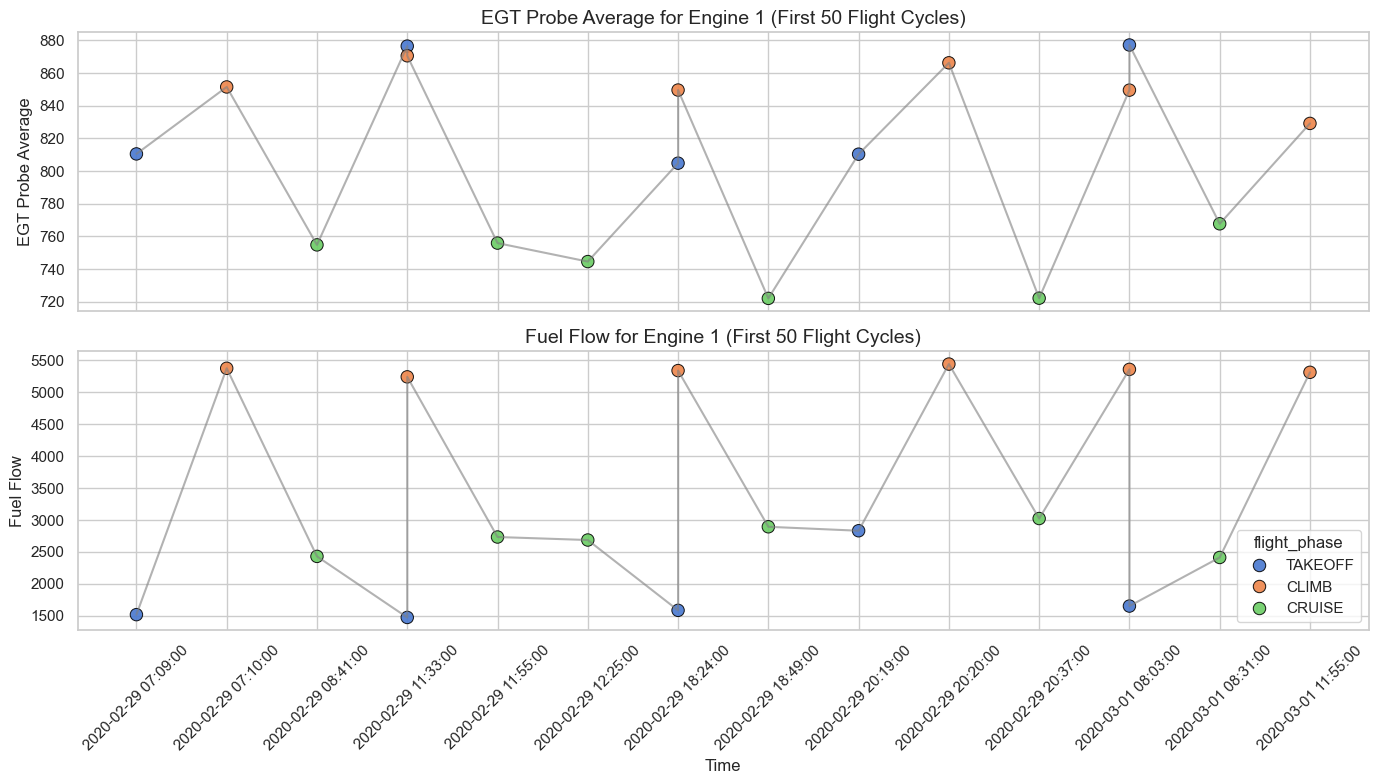

In [42]:
# Filter the DataFrame for engine number 1 
engine_number = 1
df_engine1 = df_eng2_no_outliers[df_eng2_no_outliers['eng_number'] == engine_number].copy()

# Get the data corresponding to the first 50 flight cycles
first_5_cycles = df_engine1[df_engine1['flight_cycle'] <= 5]

# Plot EGT and fuel flow for the first 50 flight cycles
plt.figure(figsize=(12, 6))

# Sort by flight_datetime_c to ensure correct line connection
df_engine = first_5_cycles.sort_values(by="flight_datetime_c")

sns.set(style="whitegrid", palette="muted")
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 1️⃣ EGT Probe Average
sns.scatterplot(
    data=df_engine, x="flight_datetime_c", y="egt_probe_average", hue="flight_phase",
    ax=axes[0], s=80, edgecolor="black", alpha=0.9, legend=False
)
axes[0].plot(df_engine["flight_datetime_c"], df_engine["egt_probe_average"], color="gray", linewidth=1.5, alpha=0.6)
axes[0].set_title("EGT Probe Average for Engine 1 (First 50 Flight Cycles)", fontsize=14)
axes[0].set_ylabel("EGT Probe Average")

# 2️⃣ Fuel Flow
sns.scatterplot(
    data=df_engine, x="flight_datetime_c", y="fuel_flw", hue="flight_phase",
    ax=axes[1], s=80, edgecolor="black", alpha=0.9
)
axes[1].plot(df_engine["flight_datetime_c"], df_engine["fuel_flw"], color="gray", linewidth=1.5, alpha=0.6)
axes[1].set_title("Fuel Flow for Engine 1 (First 50 Flight Cycles)", fontsize=14)
axes[1].set_ylabel("Fuel Flow")
axes[1].set_xlabel("Time")

# Beautify the x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



You should see a logical phase progression: takeoff → climb → cruise then repeat if multiple flights

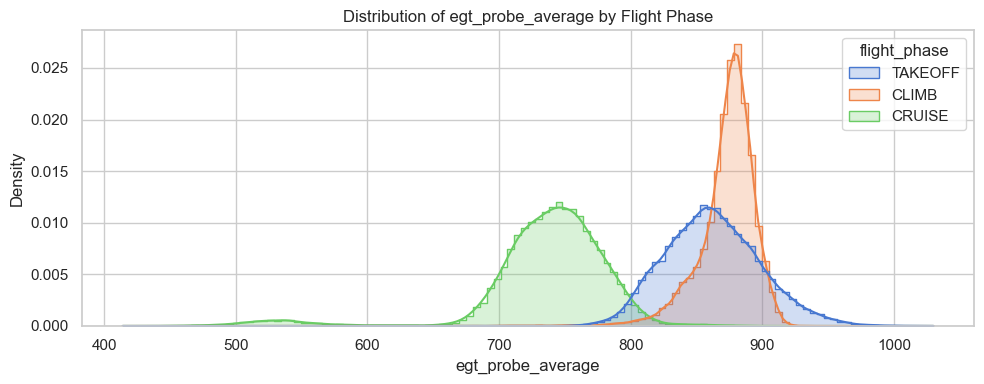

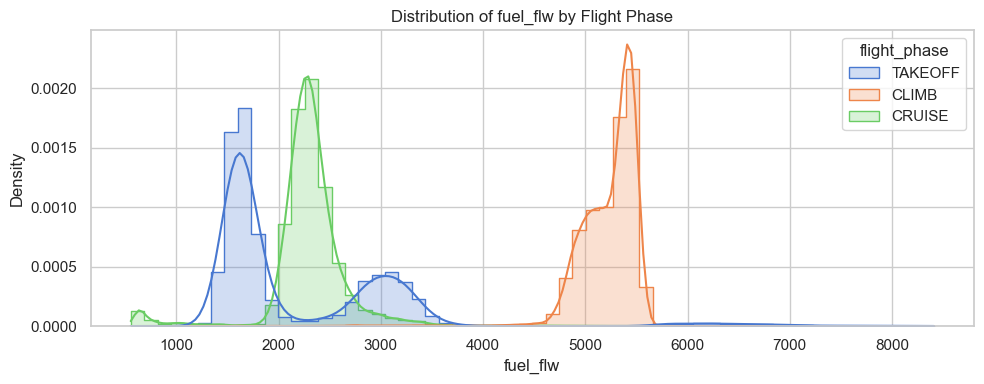

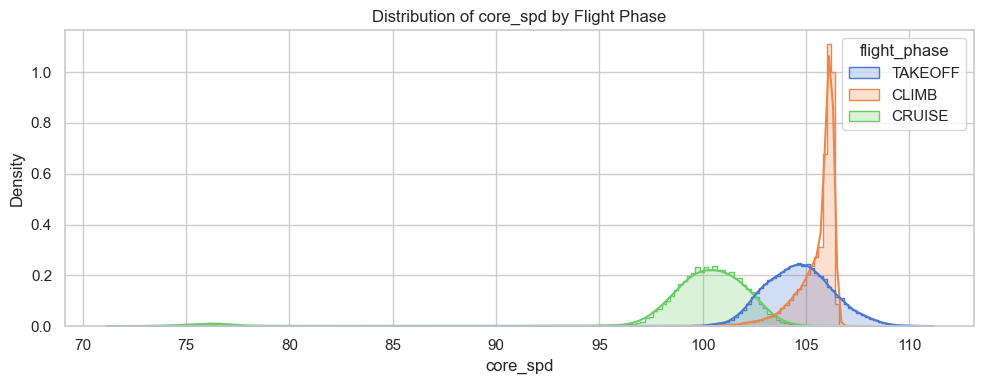

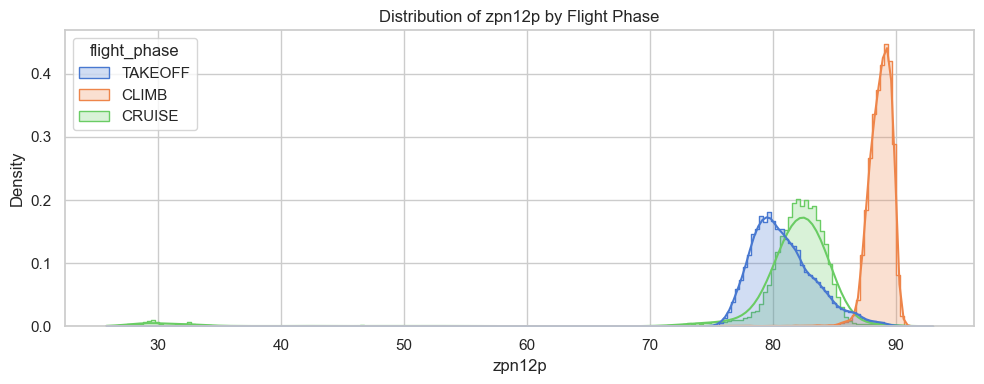

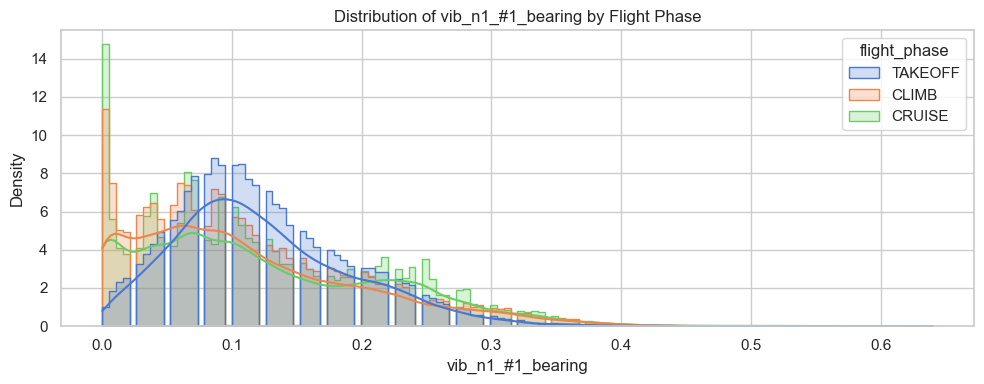

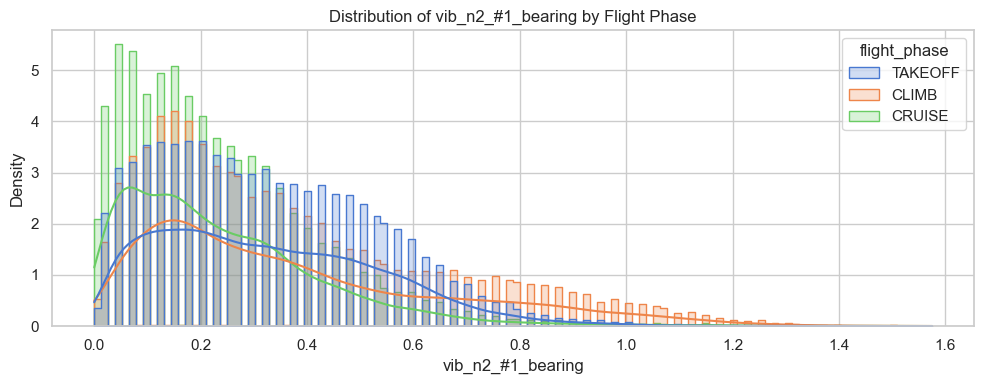

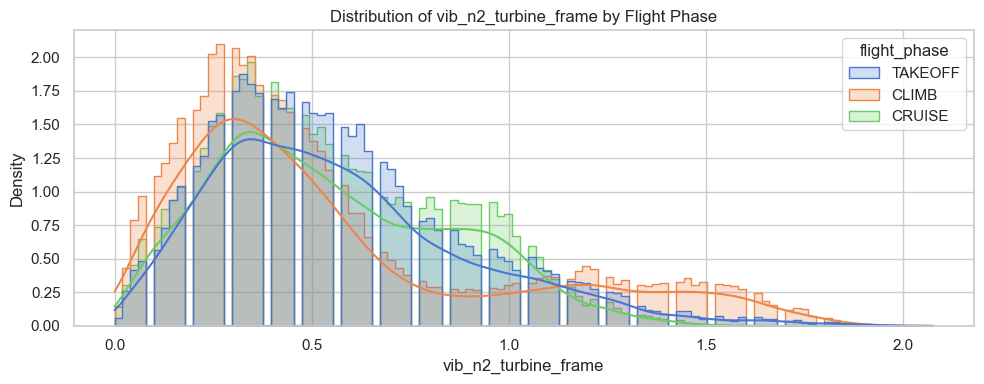

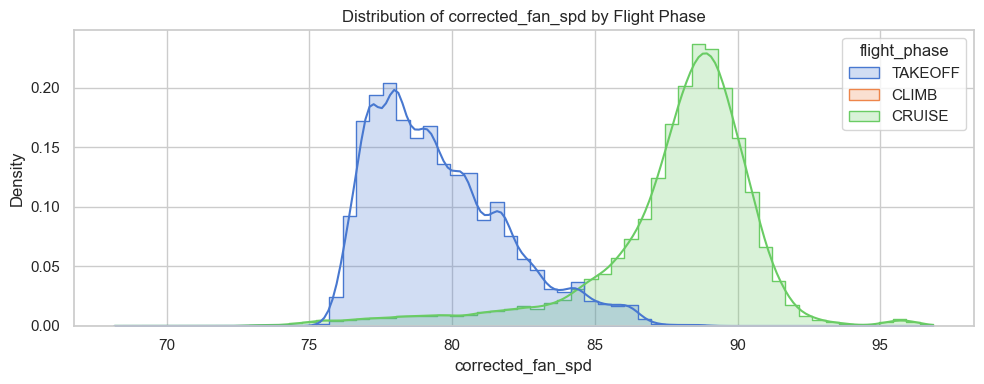

In [45]:
# plot the distribution of the numerical features color each flight_phase 
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        data=df_eng2,
        x=feature,
        hue="flight_phase",  # Color by flight_phase
        kde=True,
        element="step",      # Optional: makes plots cleaner
        stat="density",      # Normalized
        common_norm=False    # Separate KDE for each phase
    )
    plt.title(f'Distribution of {feature} by Flight Phase')
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


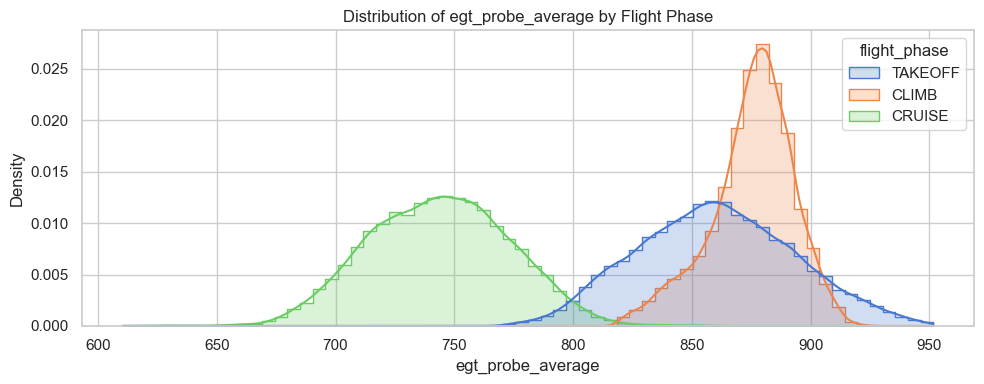

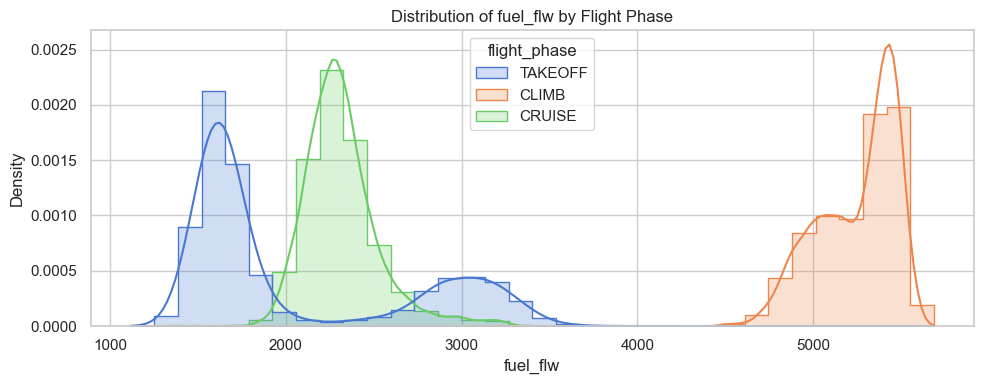

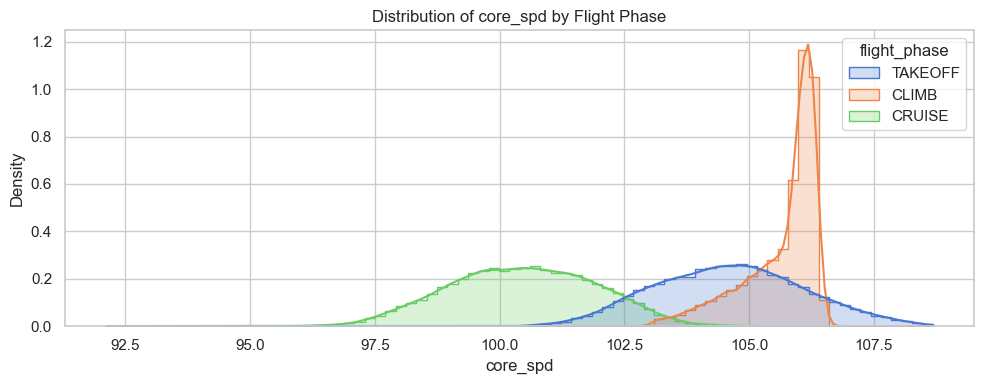

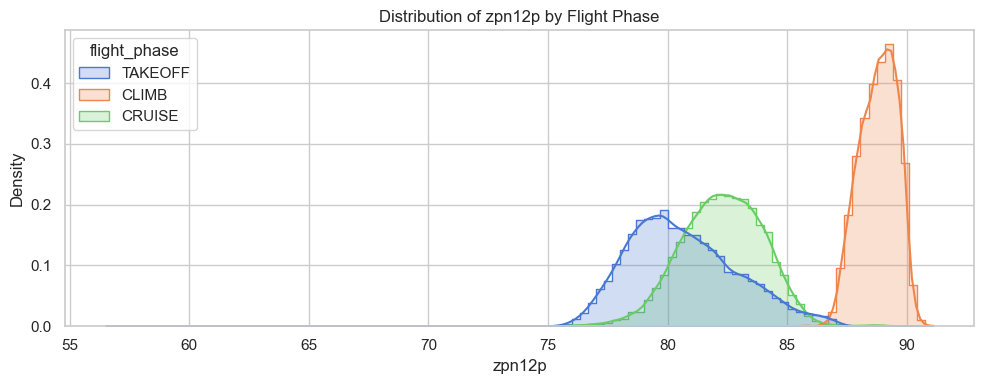

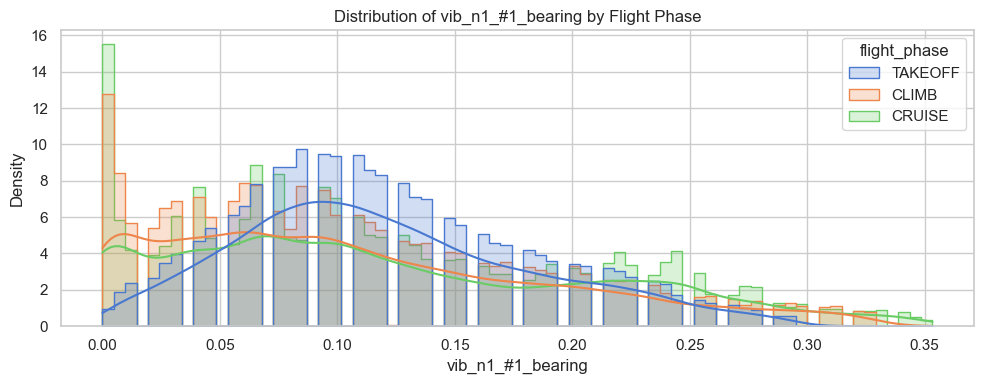

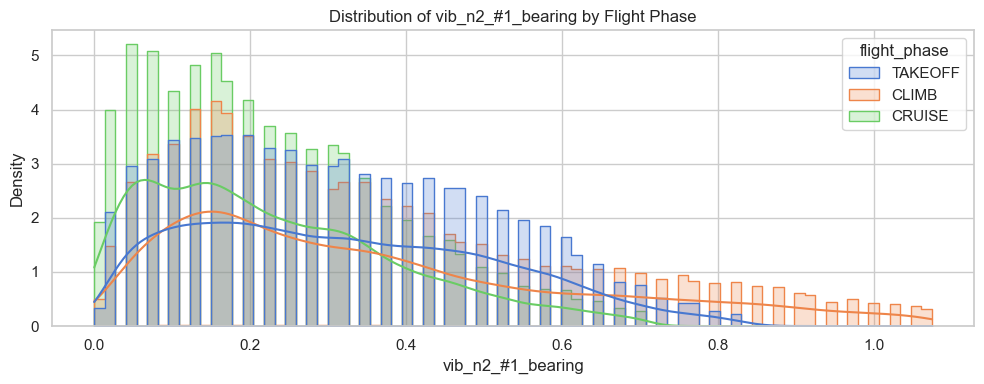

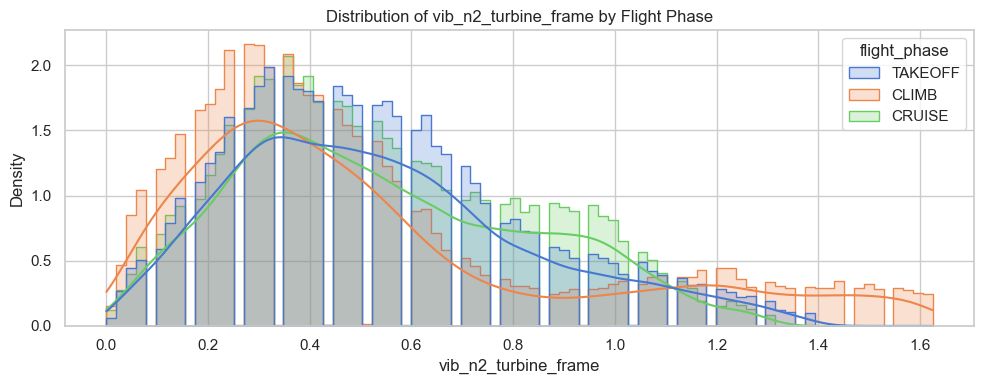

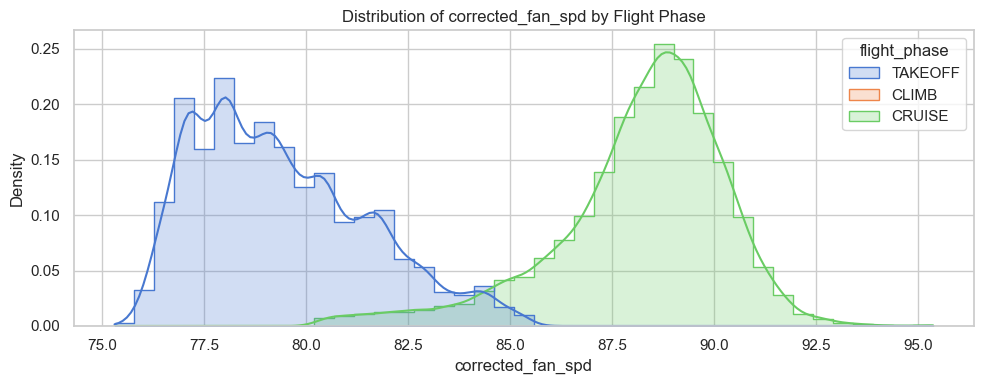

In [48]:
# plot the distribution of the numerical features color each flight_phase 
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        data=df_eng2_no_outliers,
        x=feature,
        hue="flight_phase",  # Color by flight_phase
        kde=True,
        element="step",      # Optional: makes plots cleaner
        stat="density",      # Normalized
        common_norm=False    # Separate KDE for each phase
    )
    plt.title(f'Distribution of {feature} by Flight Phase')
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


📈 Time Series Visualization (for selected engine)

In [24]:
engine_sample = df_eng2[df_eng2['eng_number'] == 3]
# smooth the data using exponential moving average
engine_sample['egt_probe_average'] = engine_sample['egt_probe_average'].ewm(span=150, adjust=False).mean()


fig = px.line(engine_sample, x='flight_cycle', y='egt_probe_average', color='flight_phase', title='EGT Over Time')
fig.show()

📉 5. Trend & Seasonality Detection

In [56]:
print(numerical_features)

['egt_probe_average', 'fuel_flw', 'core_spd', 'zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame', 'corrected_fan_spd']


In [94]:
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def detect_best_period(series, max_lag=50, plot=False, Feature_name=None):
    # Drop missing values
    series = series.dropna()

    # Calculate autocorrelations
    autocorr = acf(series, nlags=max_lag, fft=True)

    # Find peaks in autocorrelation
    peaks, _ = find_peaks(autocorr[1:])  # exclude lag=0
    if len(peaks) == 0:
        return None  # No clear seasonality
    best_lag = peaks[0] + 1  # +1 because we excluded lag 0
    #best_lag = np.argmax(autocorr[1:]) +1 #because we excluded lag 0
    if plot:
        plt.figure(figsize=(8, 3))
        plt.plot(range(len(autocorr)), autocorr, marker='o')
        plt.axvline(best_lag, color='red', linestyle='--', label=f'Seasonal Period = {best_lag}')
        plt.title(f"Autocorrelation with Detected Period for {Feature_name}")
        plt.xlabel("Lag")
        plt.ylabel("ACF")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return best_lag


In [83]:
#
df_avg = df_eng2.copy()
# Set flight_datetime_c as the index
df_avg.set_index('flight_datetime_c', inplace=True)
# Resample the DataFrame to month frequency and calculate the mean for each day
df_month_avg_cruise = df_avg[df_avg['flight_phase'] == 'CRUISE'][numerical_features].resample('M').mean()
df_month_avg_climb = df_avg[df_avg['flight_phase'] == 'CLIMB'][numerical_features].resample('M').mean()
df_month_avg_take = df_avg[df_avg['flight_phase'] == 'TAKEOFF'][numerical_features].resample('M').mean()


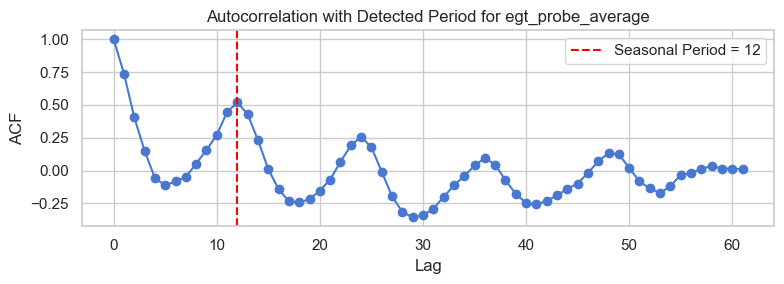

Best period for egt_probe_average in CRUISE phase: 12 months


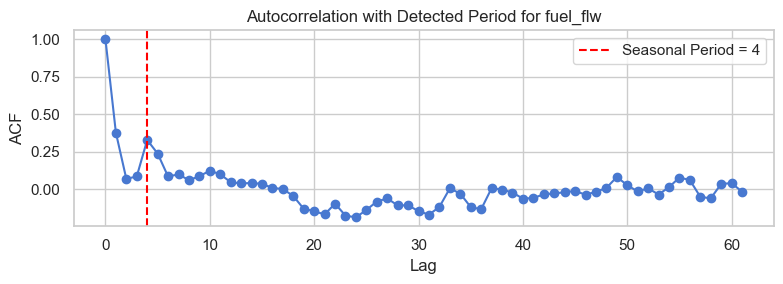

Best period for fuel_flw in CRUISE phase: 4 months


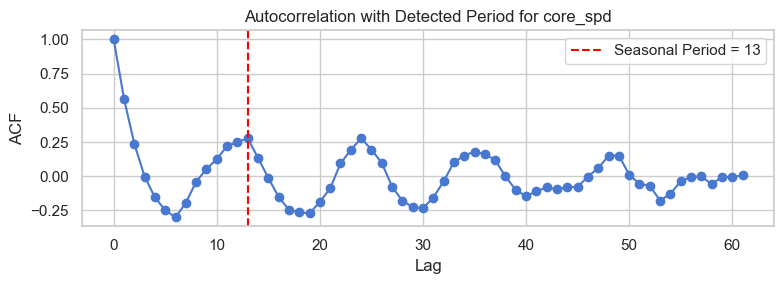

Best period for core_spd in CRUISE phase: 13 months


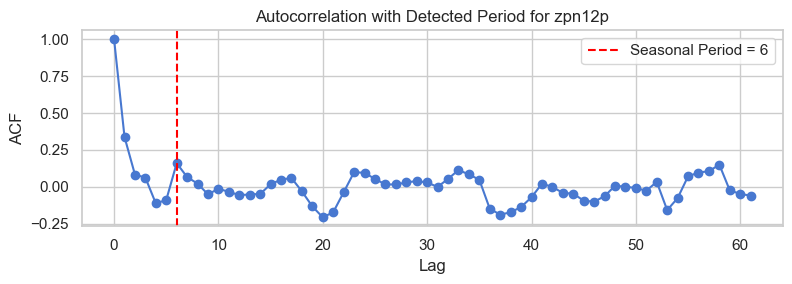

Best period for zpn12p in CRUISE phase: 6 months


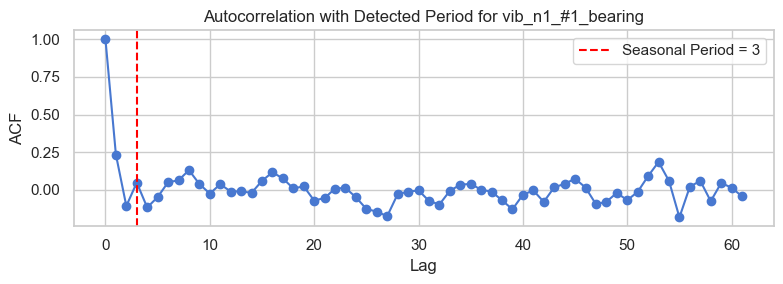

Best period for vib_n1_#1_bearing in CRUISE phase: 3 months


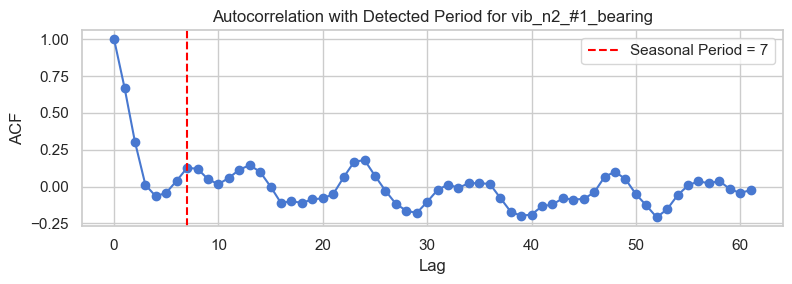

Best period for vib_n2_#1_bearing in CRUISE phase: 7 months


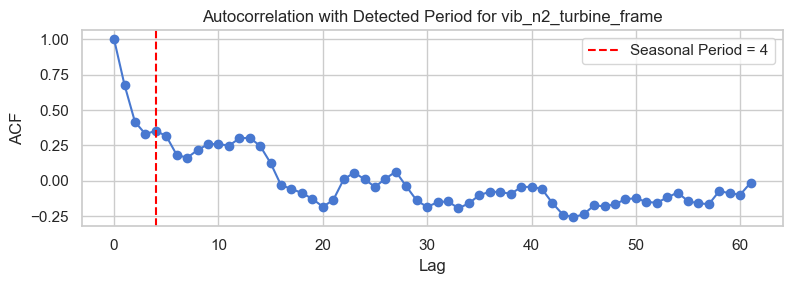

Best period for vib_n2_turbine_frame in CRUISE phase: 4 months


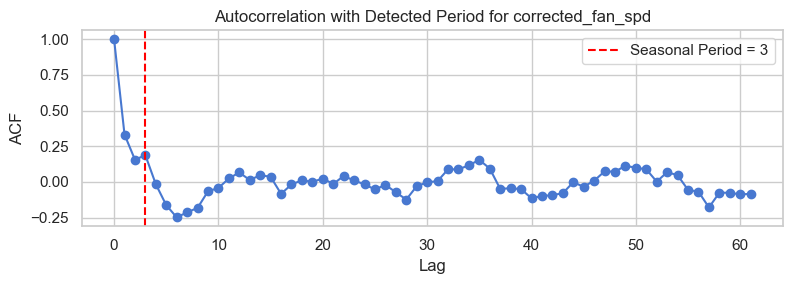

Best period for corrected_fan_spd in CRUISE phase: 3 months


In [95]:
# use detect_best_period function to detect the best period for each feature in the cruise phase
for feature in numerical_features:
    best_period = detect_best_period(df_month_avg_cruise[feature], max_lag=800, plot=True, Feature_name=feature)
    print(f"Best period for {feature} in CRUISE phase: {best_period} months")
    

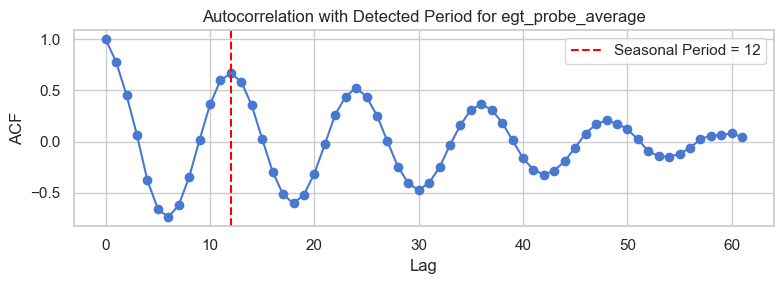

Best period for egt_probe_average in TAKEOFF phase: 12 months


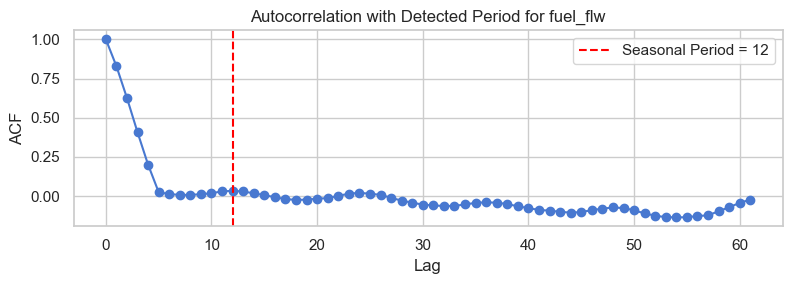

Best period for fuel_flw in TAKEOFF phase: 12 months


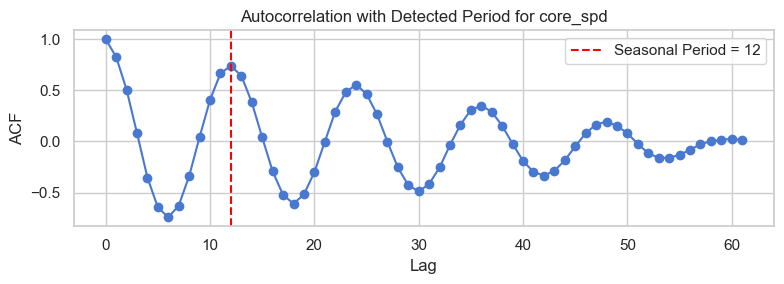

Best period for core_spd in TAKEOFF phase: 12 months


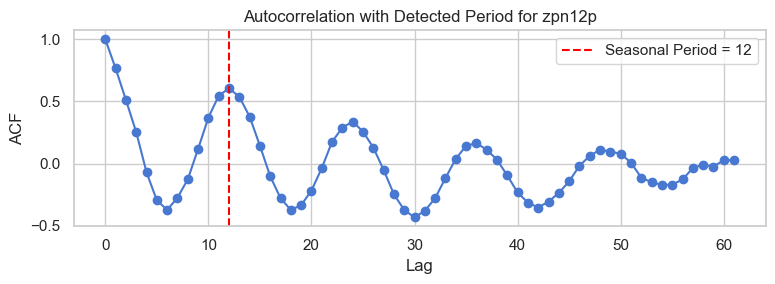

Best period for zpn12p in TAKEOFF phase: 12 months


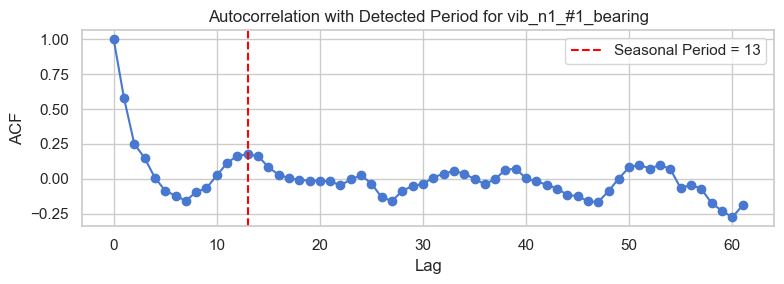

Best period for vib_n1_#1_bearing in TAKEOFF phase: 13 months


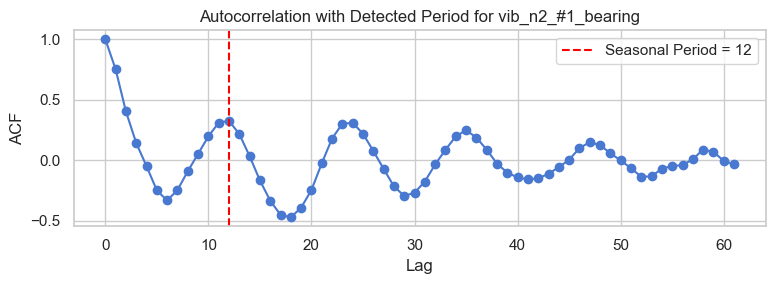

Best period for vib_n2_#1_bearing in TAKEOFF phase: 12 months


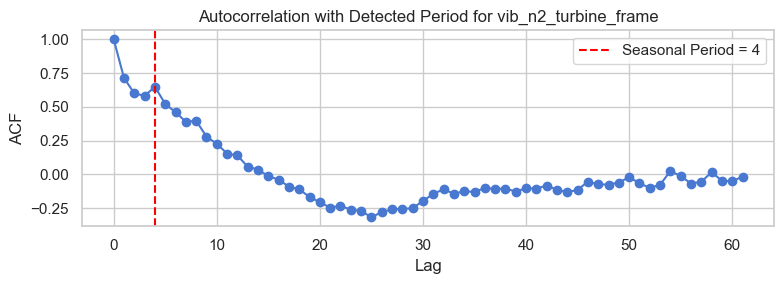

Best period for vib_n2_turbine_frame in TAKEOFF phase: 4 months


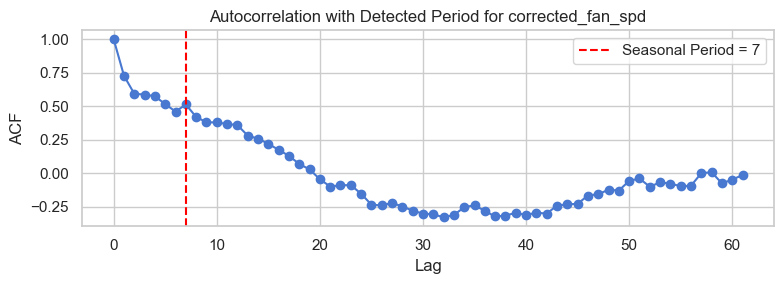

Best period for corrected_fan_spd in TAKEOFF phase: 7 months


In [96]:
# use detect_best_period function to detect the best period for each feature in the take off phase
for feature in numerical_features:
    best_period = detect_best_period(df_month_avg_take[feature], max_lag=800, plot=True, Feature_name=feature)
    print(f"Best period for {feature} in TAKEOFF phase: {best_period} months")
    

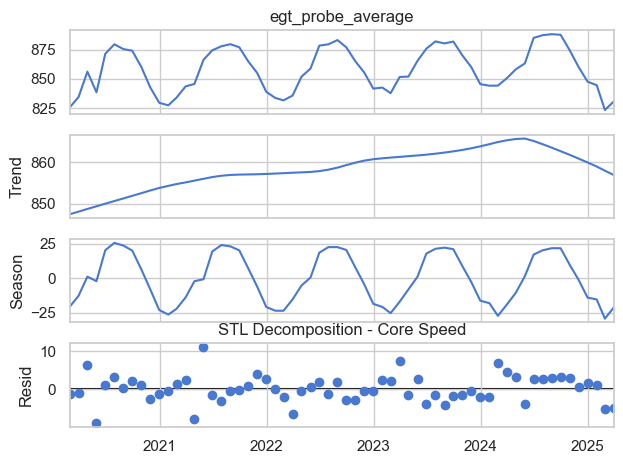

In [100]:
from statsmodels.tsa.seasonal import STL

series = df_month_avg_take['egt_probe_average']
stl = STL(series, seasonal= 13)
res = stl.fit()
res.plot()
plt.title("STL Decomposition - Core Speed")
plt.show()


Use Z-score or Isolation Forest for anomaly scores.

In [104]:
df_eng2.reset_index(drop=True, inplace=True)

In [106]:
df_eng2.head()

eposition flight_phase eng_install_date  cycles  egt_probe_average  \
0          1      TAKEOFF   19-01-20 22:00    37.0           810.5125   
1          1        CLIMB   19-01-20 22:00    38.0           851.5125   
2          1       CRUISE   19-01-20 22:00    38.0           754.8250   
3          1       CRUISE   19-01-20 22:00    38.0           577.1125   
4          1      TAKEOFF   19-01-20 22:00    38.0           876.5125   

   fuel_flw  corrected_fan_spd  core_spd  zpn12p  vib_n1_#1_bearing  \
0    1520.0            82.9875    103.19   79.21             0.1000   
1    5373.0                NaN    105.20   89.15             0.1267   
2    2431.0                NaN    102.94   83.01             0.1133   
3    1749.0                NaN     94.61   53.87             0.0733   
4    1476.0            82.9875    106.00   84.16             0.0600   

   vib_n2_#1_bearing  vib_n2_turbine_frame  eng_type  eng_number  \
0              0.275                  0.70         2           1   
1              0.375                  0.50         2           1   
2              0.425                  0.55         2           1   
3              0.050                  0.85         2           1   
4              0.225                  0.60         2           1   

    flight_datetime_c        date      time  flight_cycle   RUL  
0 2020-02-29 07:09:00  2020-02-29  07:09:00             1  4428  
1 2020-02-29 07:10:00  2020-02-29  07:10:00             1  4428  
2 2020-02-29 08:41:00  2020-02-29  08:41:00             1  4428  
3 2020-02-29 09:34:00  2020-02-29  09:34:00             1  4428  
4 2020-02-29 11:33:00  2020-02-29  11:33:00             2  4427

In [110]:
from sklearn.ensemble import IsolationForest
numerical_features_nofan = ['egt_probe_average', 'fuel_flw','core_spd', 'zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame']
# Create a sample DataFrame for engine number 1 for takeoff phase
sample_engine = df_eng2[df_eng2['eng_number'] == 1].copy()
sample_engine = sample_engine[sample_engine['flight_phase'] == 'TAKEOFF'].copy()    
# Plot anomalies 
iso = IsolationForest(contamination=0.01)
sample_engine['anomaly'] = iso.fit_predict(sample_engine[numerical_features_nofan])
anomalies = sample_engine[sample_engine['anomaly'] == -1]



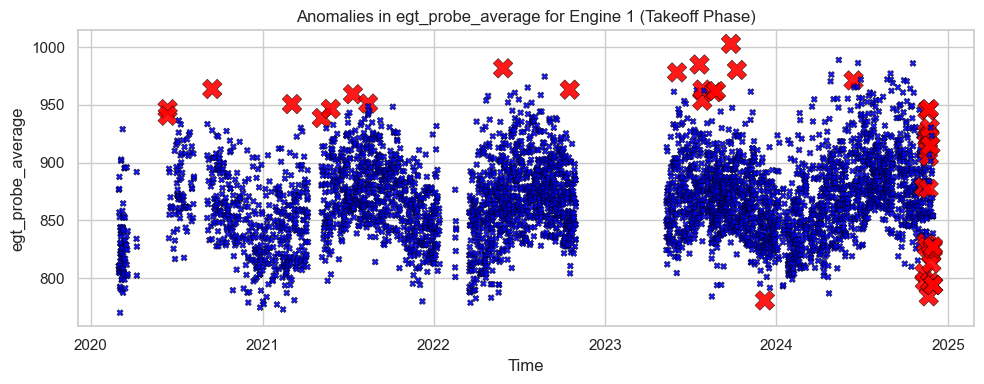

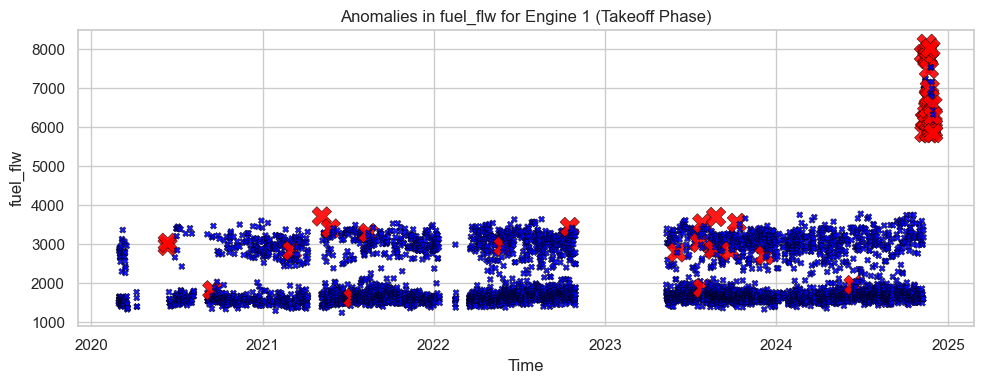

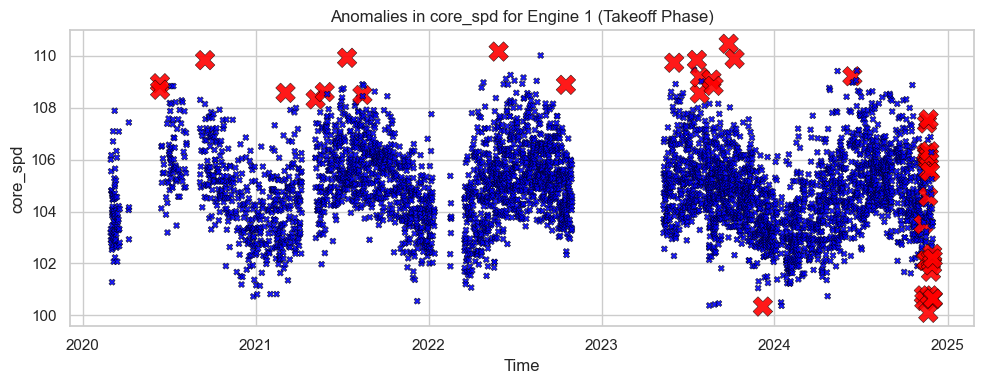

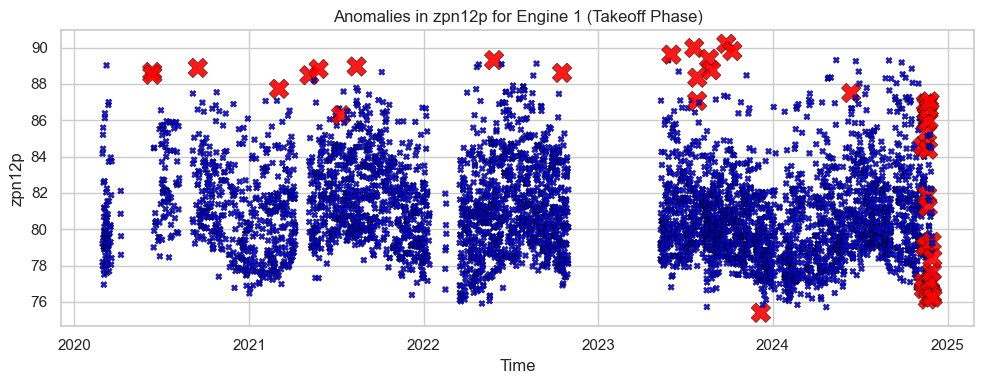

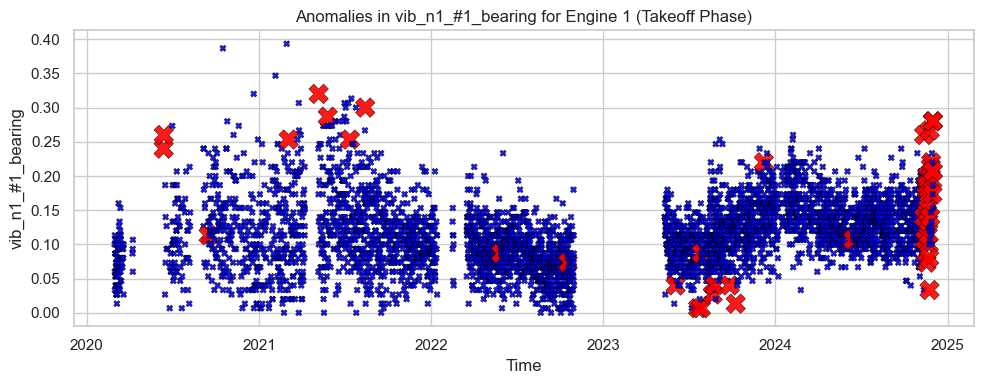

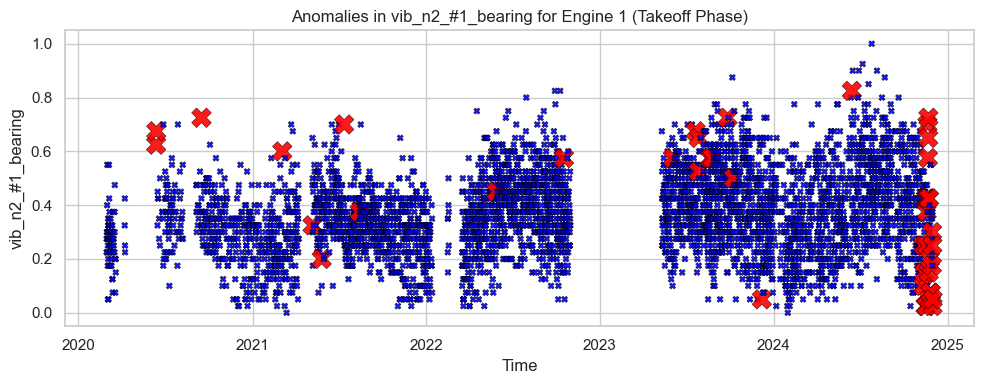

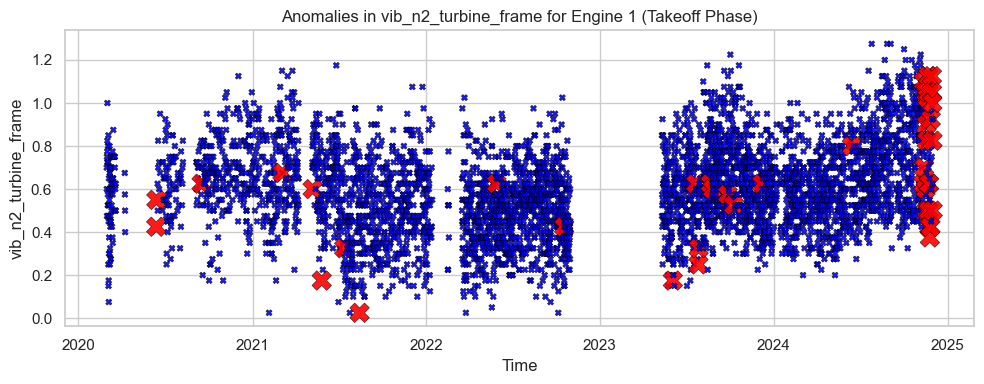

In [113]:
# plot anomalies for numerical_features_nofan

for feature in numerical_features_nofan:
    plt.figure(figsize=(10, 4))
    sns.scatterplot(
        data=sample_engine, x="flight_datetime_c", y=feature, hue="anomaly",
        palette={1: "blue", -1: "red"},  # Blue for normal, red for anomalies
        s=sample_engine['anomaly'].apply(lambda x: 200 if x == -1 else 20),  # Larger size for anomalies
        edgecolor="black", alpha=0.9, legend=False, marker="X" if sample_engine['anomaly'].eq(-1).any() else "o"
    )
    plt.title(f'Anomalies in {feature} for Engine 1 (Takeoff Phase)')
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

as seen obviously anomalies incres towards last cycles in engine life

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


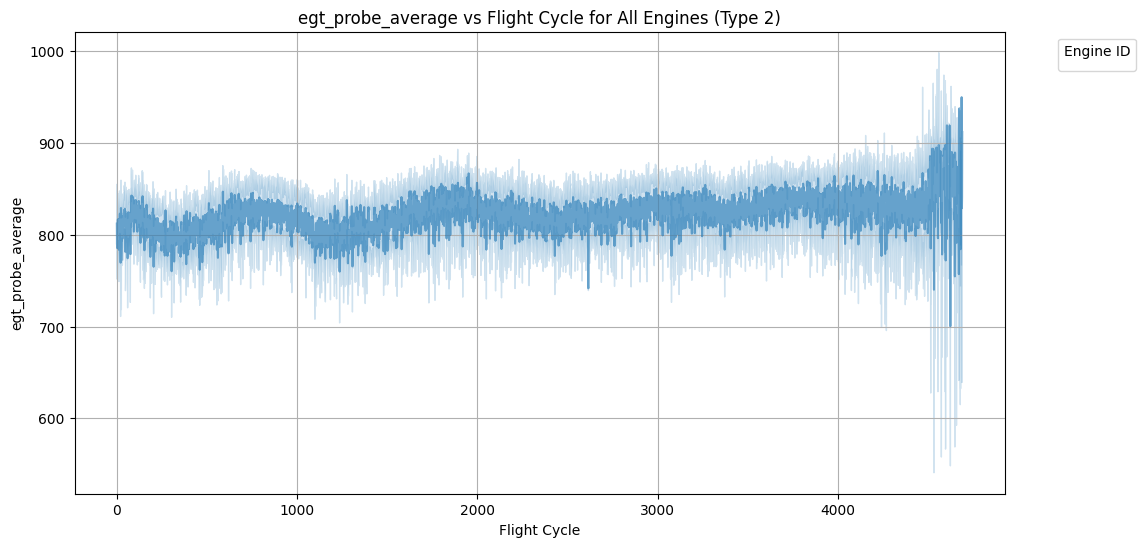

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


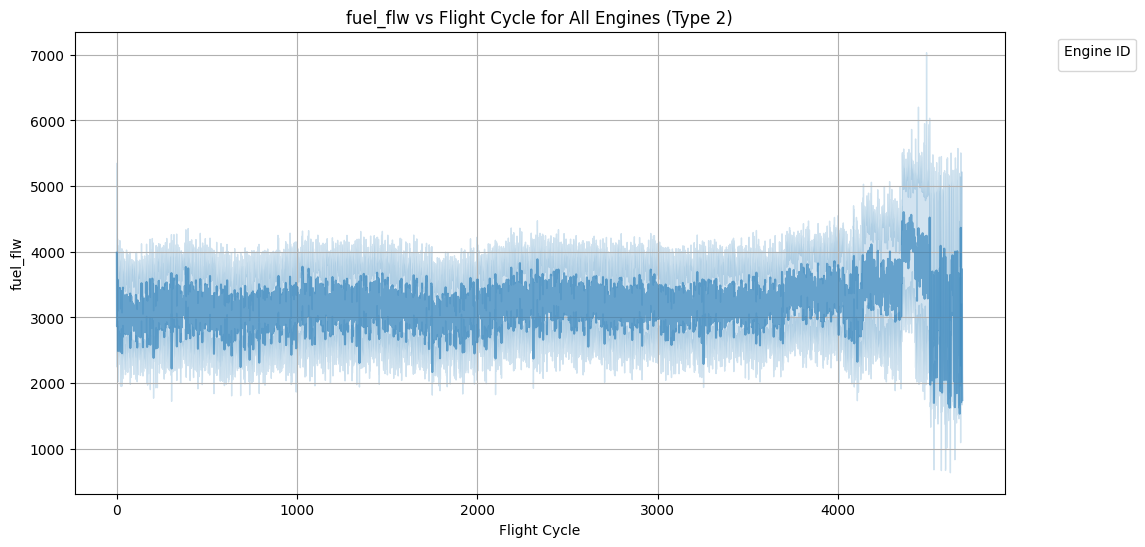

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


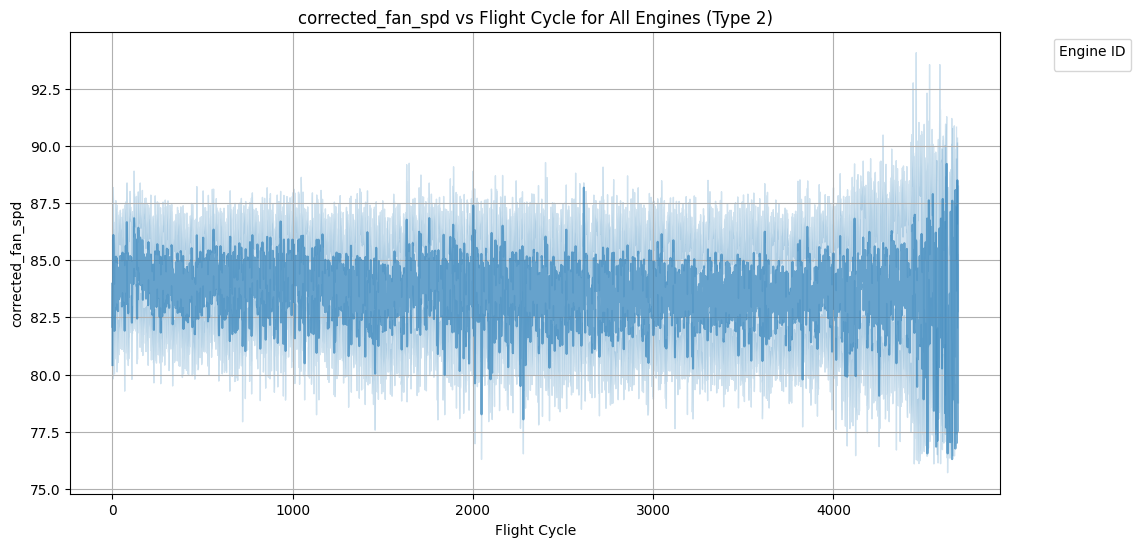

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


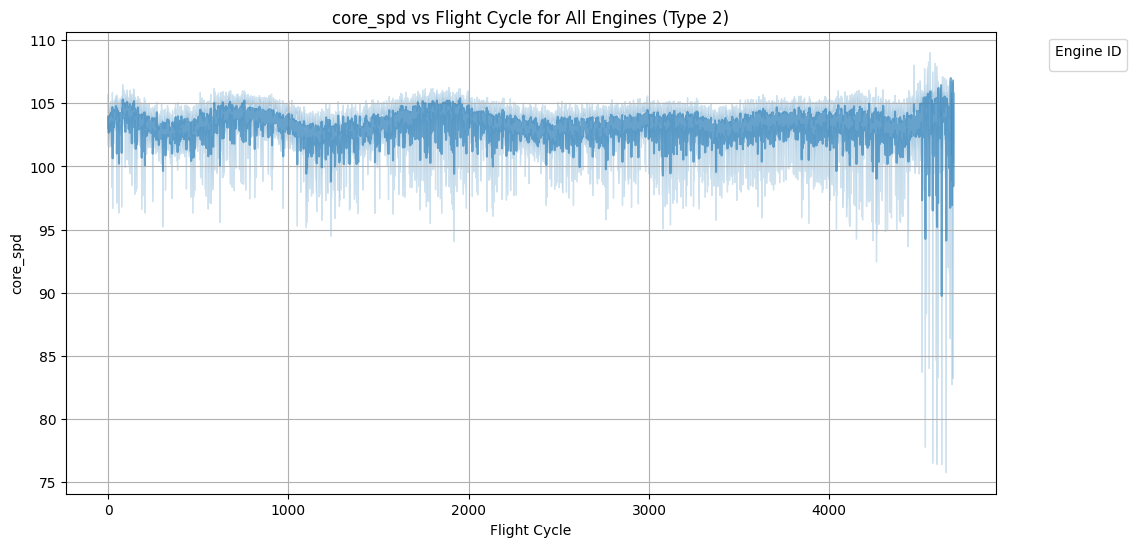

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


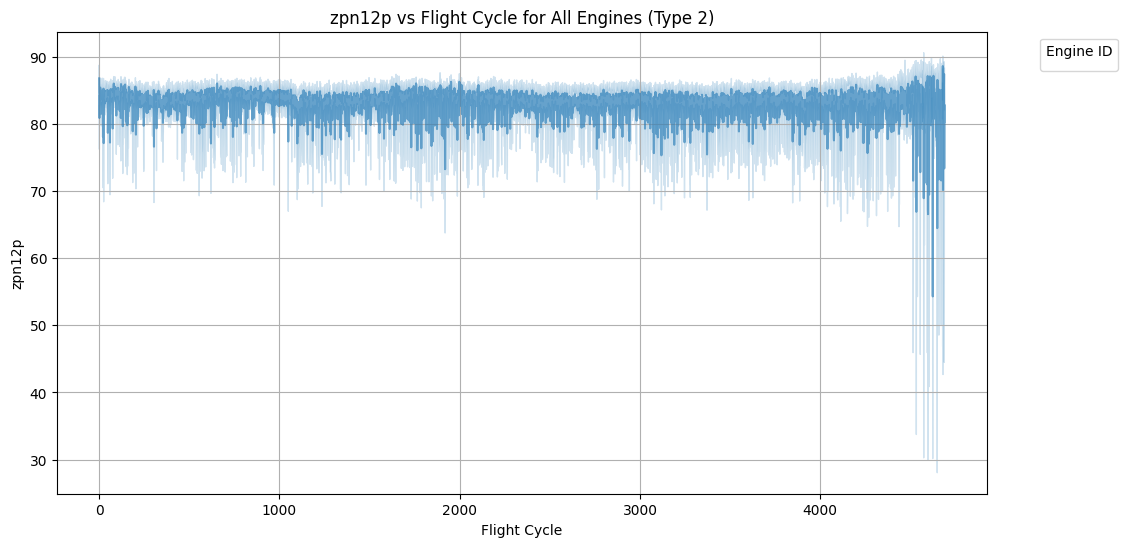

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


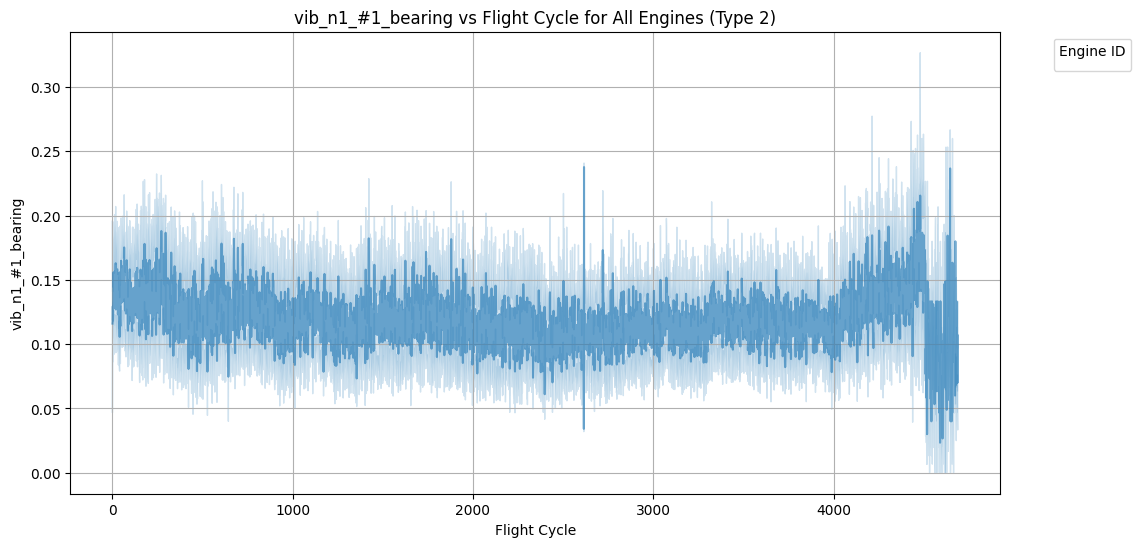

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


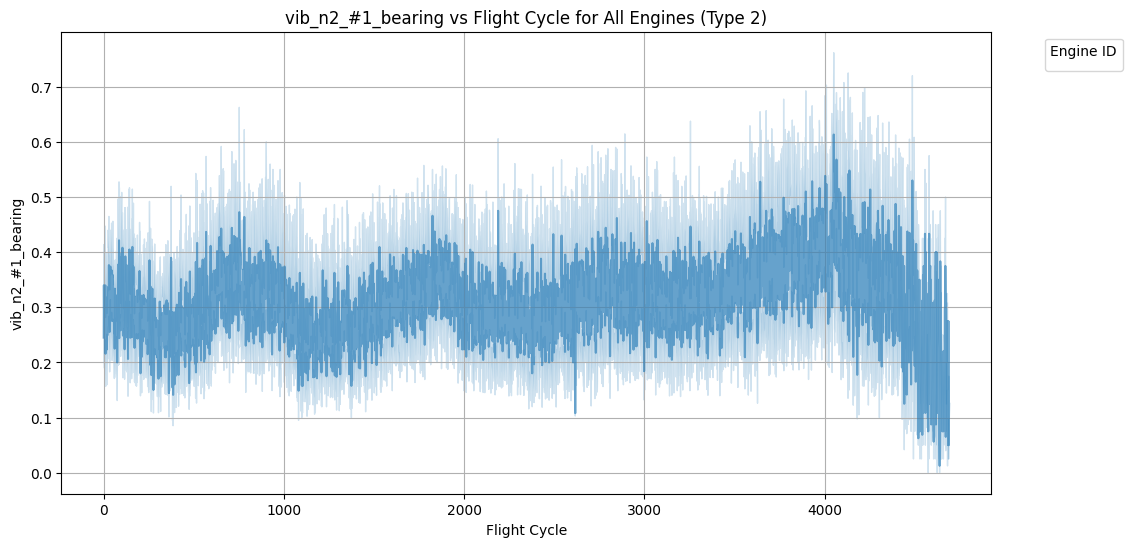

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_14048\2294280424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')


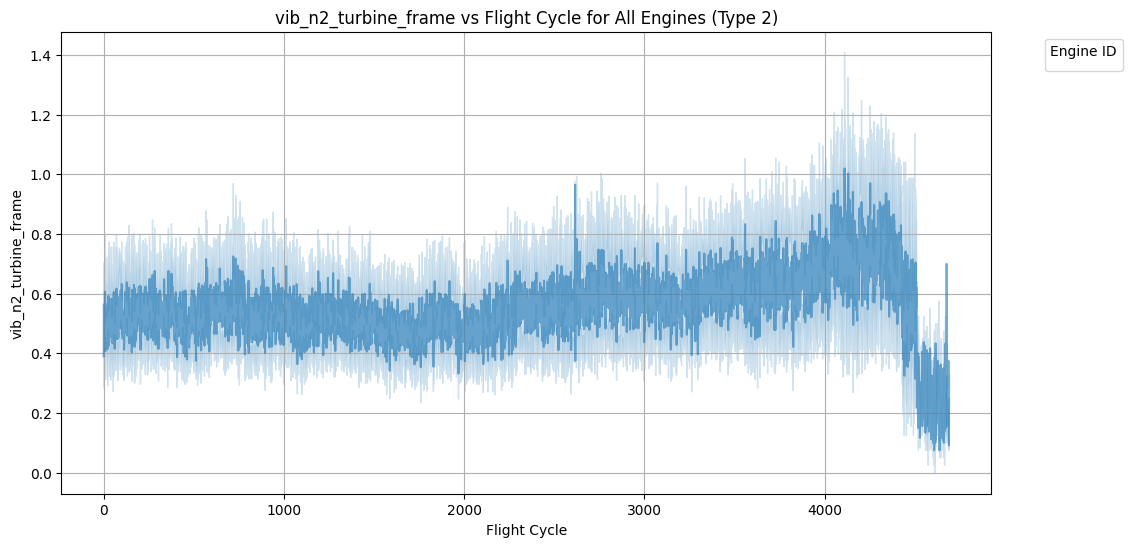

In [54]:
# for each of the following features 'egt_probe_average', 'fuel_flw', 'corrected_fan_spd', 'core_spd','zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing','vib_n2_turbine_frame',
# plot a line chart for all engines against flight_cycle

features = ['egt_probe_average', 'fuel_flw', 'corrected_fan_spd', 'core_spd','zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing','vib_n2_turbine_frame']
for feature in features:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_eng2, x='flight_cycle', y=feature, estimator='mean', alpha=0.6)
    plt.title(f"{feature} vs Flight Cycle for All Engines (Type 2)")
    plt.xlabel("Flight Cycle")
    plt.ylabel(feature)
    plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.show()
    

In [130]:
# use PCA to reduce the dimensionality of the data

scaled_data = StandardScaler().fit_transform(df_eng2_no_outliers[numerical_features_nofan])
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)
# show the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {np.sum(explained_variance)}")


Explained variance ratio: 0.9475801678316254
